Lien de téléchargement des données: https://cvml.ista.ac.at/AwA2/        

13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=ab7f15df6bbee6f874764ae6e69430adaffec29f4850659cf13970f1231832b9
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
!wandb login # Il faut entrer un mot de passe pour login,
             # veuillez entrer dans le prompt: f26c1f8c1968c614fe4b7290f20d5221aa5cb15d 

wandb: Currently logged in as: yuyangxiong23. Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="ResNet18-Aug-PreTrain-50epoches-versionToSubmit",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "ResNet",
    "dataset": "AWA2",
    "epochs": 10,
    }
)

wandb: Currently logged in as: yuyangxiong23. Use `wandb login --relogin` to force relogin


# Note!!! Veuillez lire le phrase suivante avant d'exécuter tout code
Exécutez les deux blocs de codes qui suivent seulement si vous allez exécuter ce ficher sur Colab. Ignorez-les sinon.

`Importer dataset AwA2 dans Colab. Assurez-vous bien que dataset "Animals_with_Attributes2" se trouve dans votre Google Drive.`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
shutil.copytree('/content/drive/MyDrive/Animals_with_Attributes2/','AWA2')

'AWA2'

# Environnement dont on aura besoin:

In [3]:
import sys
import cv2 # Pour utiliser open_cv, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(0)

## Note!!! Veuillez d'abord lire le texte suivant avant d'exécuter les blocs de codes suivants
Si vous venez d'exécuter ces deux blocs de codes-là au début du fichier, vous pouvez exécuter le bloc qui suit sans toute modification.
Sinon, vous devez modifier les deux chemins, le premier vers le dossier "Animals_with_Attributes2" dans votre environnement, le deuxième vers son sous-dossier "JPEGImages".


In [4]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
DATA_FOLDER_PATH = '/content/AWA2/'
JPEGIMAGES_FOLDER_PATH = '/content/AWA2/JPEGImages/'

# Note : Some labels have a low number of images. 

## Possible solutions to explore : 
    Data augmentation : creating new training data by applying random transformations to existing images, such as rotating, cropping, or flipping them.

In [5]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH): #-> tuple[dict,dict]: 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    labels_dirs = [f for f in labels_dirs if not f.startswith('.')] # remove hidden files
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()

In [6]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """
    
    labels_dirs:list = os.listdir(img_dir)
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

create_annotations_csv_file()

Sucessfully created annotations.csv file.


In [7]:
labels_dict = {}
with open(DATA_FOLDER_PATH+"classes.txt") as f:
    for line in f:
        (key,val) = line.split()
        labels_dict[val] = int(key)-1
print(labels_dict)

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49}


In [8]:
from torchvision.io import read_image, ImageReadMode
from PIL import Image


class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        key = self.img_labels.iloc[idx, 1]

        # Mapping the labels from string to tensor
        label = labels_dict[key]

        image = read_image(path = img_path, mode = ImageReadMode.RGB)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


class Subset_(AWA2Dataset) : 
    def __init__(self, dataset, indices, transform=None):
        super().__init__()
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        original_index_in_AWA2Dataset = self.indices[index]
        image, label = self.dataset[original_index_in_AWA2Dataset]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    

In [9]:
transforms_pipeline_train = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    # transforms.Grayscale(num_output_channels=3),
                    
                    ## Data augmentation 
                    transforms.RandomRotation(15),
                    transforms.RandomHorizontalFlip(p=0.4),
                    # transforms.RandomApply(transforms.RandAugment(), p=0.4), # 40% of the time, apply a random additional combo of transformations #https://sebastianraschka.com/blog/2023/data-augmentation-pytorch.html
                    transforms.ColorJitter(brightness=0.2,
                                            contrast=0.2,
                                            saturation=0.2,
                                            hue=0.1),
                    transforms.RandomCrop((224,224)),  # transforms.RandomResizedCrop(size=(224,224), scale=(0.6, 0.9), ratio=(0.5, 1.08,))
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


transforms_pipeline_test = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    # transforms.Grayscale(num_output_channels=3),
                    transforms.CenterCrop((224,224)),   
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


transforms_resize = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((224,224)),

                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


# Initialize dataset and train/valid/test split 
from sklearn.model_selection import train_test_split

dataset = AWA2Dataset()
n_images = len(dataset)
# Split all indices into training/testing sets
train_indices, test_indices = train_test_split(range(n_images), test_size=0.2, random_state=1)
# Split training indices into training/validation sets.
train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, random_state=1)


"""
You can comment the following 3 lines of codes and uncomment the 3 lines of codes 
following "# W/O data augmentation" to use the dataset without data augmentation.
"""
# Initialize the 3 DataSet objects (as Subset_) and apply the relevant Transforms to each subset (train/test/valid)
train_data = Subset_(dataset, train_indices, transform = transforms_pipeline_train)
valid_data = Subset_(dataset, valid_indices, transform = transforms_pipeline_test)
test_data  = Subset_(dataset, test_indices, transform = transforms_pipeline_test) 

# W/O data augmentation
# train_data = Subset_(dataset, train_indices, transform = transforms_resize)
# valid_data = Subset_(dataset, valid_indices, transform = transforms_resize)
# test_data  = Subset_(dataset, test_indices, transform = transforms_resize) 

# Initalize DataLoaders
batch_size = 64
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

# Importation de ResNet et Entraînement:

## Importation de ResNet:

In [10]:
from torchvision import models
resnet = models.resnet18(pretrained=True) # You can switch "True" to "False" to import a model non pre-trained

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 371MB/s]


## Entraînement de ResNet:

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is available


In [12]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import torch.nn as nn
from tqdm.notebook import tqdm

model = resnet

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    # log metrics to wandb
    # wandb.log({"loss" : epoch_loss , "acc": epoch_accuracy, "val_loss" : epoch_val_loss, "val_acc": epoch_val_accuracy})

  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.9797 - acc: 0.7169 - val_loss : 0.7686 - val_acc: 0.7722



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.7488 - acc: 0.7742 - val_loss : 0.6662 - val_acc: 0.7937



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6190 - acc: 0.8117 - val_loss : 0.6258 - val_acc: 0.8109



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.5475 - acc: 0.8312 - val_loss : 0.6062 - val_acc: 0.8147



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.4827 - acc: 0.8508 - val_loss : 0.5855 - val_acc: 0.8220



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.4404 - acc: 0.8614 - val_loss : 0.5609 - val_acc: 0.8390



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.3870 - acc: 0.8761 - val_loss : 0.5770 - val_acc: 0.8253



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.3650 - acc: 0.8814 - val_loss : 0.5532 - val_acc: 0.8336



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.3313 - acc: 0.8950 - val_loss : 0.5565 - val_acc: 0.8434



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.2979 - acc: 0.9019 - val_loss : 0.5845 - val_acc: 0.8313



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.2637 - acc: 0.9144 - val_loss : 0.5615 - val_acc: 0.8411



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.2744 - acc: 0.9097 - val_loss : 0.5548 - val_acc: 0.8472



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.2334 - acc: 0.9233 - val_loss : 0.5920 - val_acc: 0.8399



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.2345 - acc: 0.9251 - val_loss : 0.5656 - val_acc: 0.8463



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.2323 - acc: 0.9245 - val_loss : 0.6129 - val_acc: 0.8453



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.1923 - acc: 0.9385 - val_loss : 0.6041 - val_acc: 0.8422



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.1932 - acc: 0.9370 - val_loss : 0.5827 - val_acc: 0.8421



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.1907 - acc: 0.9378 - val_loss : 0.5681 - val_acc: 0.8490



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.1667 - acc: 0.9460 - val_loss : 0.5880 - val_acc: 0.8414



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.1585 - acc: 0.9478 - val_loss : 0.6127 - val_acc: 0.8471



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.1618 - acc: 0.9471 - val_loss : 0.6331 - val_acc: 0.8393



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.1218 - acc: 0.9585 - val_loss : 0.6542 - val_acc: 0.8394



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.1569 - acc: 0.9473 - val_loss : 0.6666 - val_acc: 0.8358



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.1345 - acc: 0.9555 - val_loss : 0.6401 - val_acc: 0.8405



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.1498 - acc: 0.9517 - val_loss : 0.6524 - val_acc: 0.8393



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.1340 - acc: 0.9565 - val_loss : 0.6361 - val_acc: 0.8510



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.1116 - acc: 0.9617 - val_loss : 0.6312 - val_acc: 0.8468



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.1106 - acc: 0.9627 - val_loss : 0.6418 - val_acc: 0.8468



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.1050 - acc: 0.9648 - val_loss : 0.6719 - val_acc: 0.8509



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.1093 - acc: 0.9636 - val_loss : 0.6588 - val_acc: 0.8509



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.1423 - acc: 0.9541 - val_loss : 0.6375 - val_acc: 0.8461



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.0983 - acc: 0.9679 - val_loss : 0.6587 - val_acc: 0.8455



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.1047 - acc: 0.9670 - val_loss : 0.6536 - val_acc: 0.8523



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.1022 - acc: 0.9679 - val_loss : 0.6801 - val_acc: 0.8442



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.0904 - acc: 0.9713 - val_loss : 0.6826 - val_acc: 0.8473



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.0955 - acc: 0.9692 - val_loss : 0.6644 - val_acc: 0.8493



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.0980 - acc: 0.9687 - val_loss : 0.6664 - val_acc: 0.8502



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.0873 - acc: 0.9716 - val_loss : 0.6895 - val_acc: 0.8443



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.0813 - acc: 0.9743 - val_loss : 0.6584 - val_acc: 0.8533



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.0842 - acc: 0.9736 - val_loss : 0.7291 - val_acc: 0.8408



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.0890 - acc: 0.9717 - val_loss : 0.7137 - val_acc: 0.8518



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.0778 - acc: 0.9743 - val_loss : 0.7298 - val_acc: 0.8471



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.0683 - acc: 0.9782 - val_loss : 0.7292 - val_acc: 0.8467



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.0941 - acc: 0.9698 - val_loss : 0.6798 - val_acc: 0.8506



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.0789 - acc: 0.9757 - val_loss : 0.7012 - val_acc: 0.8490



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.0678 - acc: 0.9778 - val_loss : 0.7299 - val_acc: 0.8493



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.0894 - acc: 0.9702 - val_loss : 0.7337 - val_acc: 0.8468



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.0744 - acc: 0.9758 - val_loss : 0.7358 - val_acc: 0.8439



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.0704 - acc: 0.9773 - val_loss : 0.7163 - val_acc: 0.8458



  0%|          | 0/374 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.0712 - acc: 0.9774 - val_loss : 0.6996 - val_acc: 0.8536



# Test de ResNet sur "test dataset":

In [ ]:
from sklearn.metrics import classification_report

model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    wrong_pred =[]
    right_label = []

    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)

        output = model(image)
        _, predicted = torch.max(output.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(label.tolist())
        total += label.size(0)

        for i in range(0,len(predicted)):
              if predicted[i].item() != label[i].item():
                    wrong_pred.append(predicted[i].item())
                    right_label.append(label[i].item())

        correct += (predicted == label).sum().item()

print('Accuracy of the model on the test images: {:.2f}%'.format(100 * correct / total))

Accuracy of the model on the test images: 91.86%


# Analyse du résultat du test:

## 1. Rapport de classification:

In [ ]:
print(classification_report(y_true, y_pred)) 

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       214
           1       0.96      0.93      0.94       175
           2       0.92      0.98      0.95        56
           3       0.72      0.88      0.79        32
           4       0.98      0.95      0.96       128
           5       0.84      0.91      0.87       137
           6       0.92      0.95      0.93       329
           7       0.88      0.84      0.86       197
           8       0.64      0.88      0.74        32
           9       0.97      0.89      0.93       100
          10       0.92      0.92      0.92        37
          11       1.00      0.80      0.89        25
          12       1.00      0.99      1.00       175
          13       0.89      0.91      0.90       144
          14       0.99      0.98      0.99       141
          15       0.89      0.89      0.89       147
          16       0.82      0.85      0.83        59
          17       0.93    

## 2. Matrice de confusion:

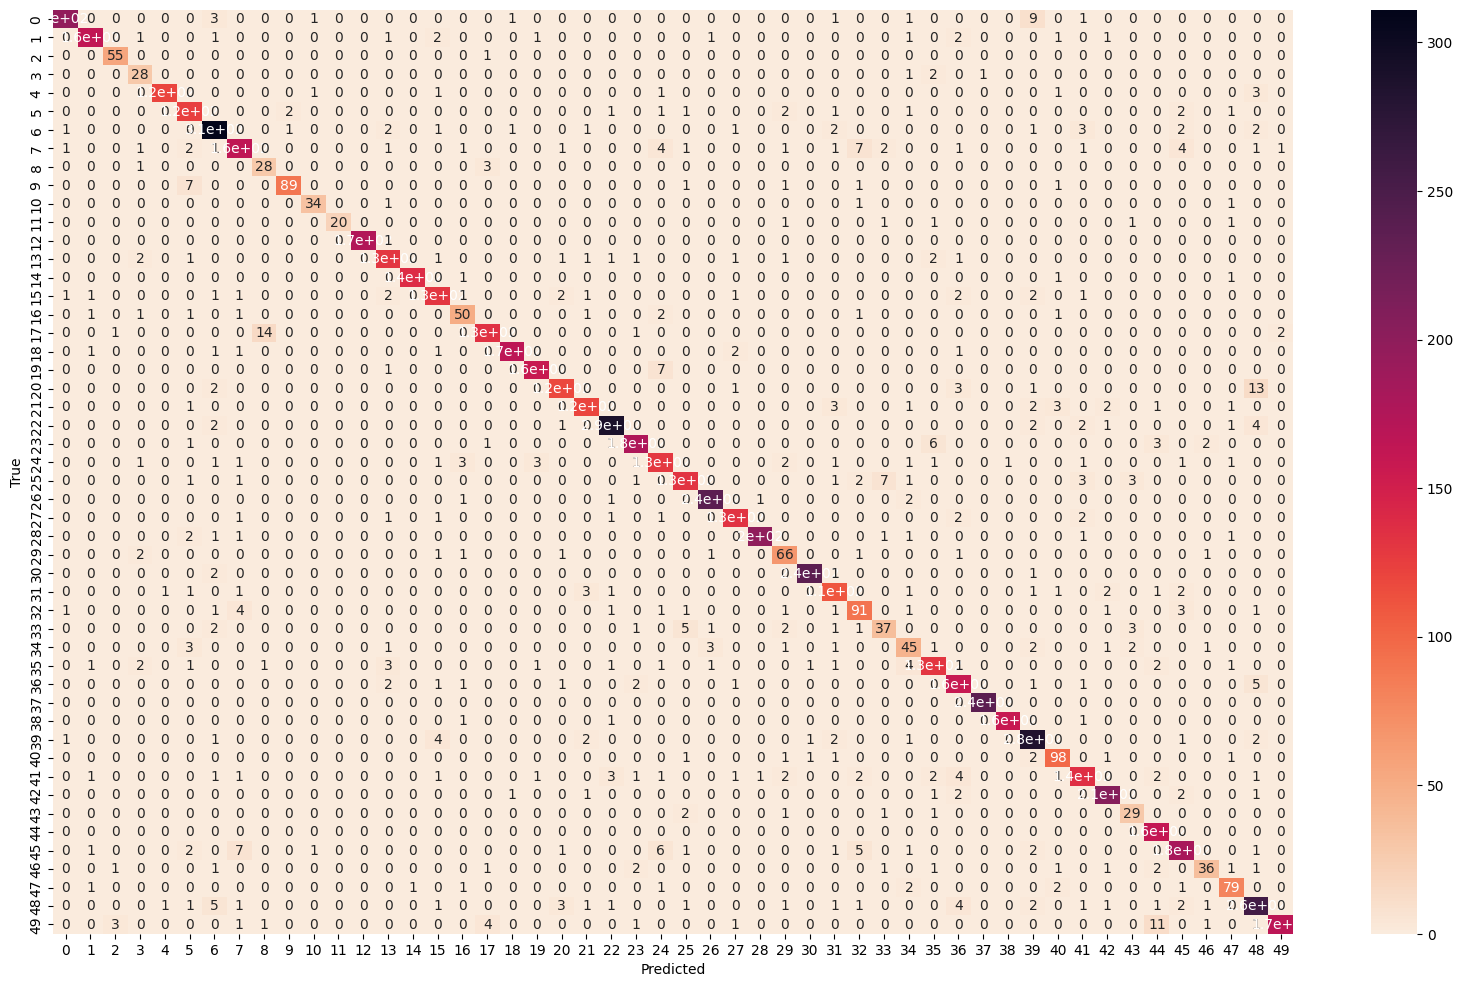

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, y_pred)

# Seaborn heatmap
fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(confusion_mat, annot=True, cmap='rocket_r')

# set plot labels
plt.xlabel('Predicted')
plt.ylabel('True')

# show plot
plt.show()

## 3. Graphique histogramme de la distribution des classes mal prédites:

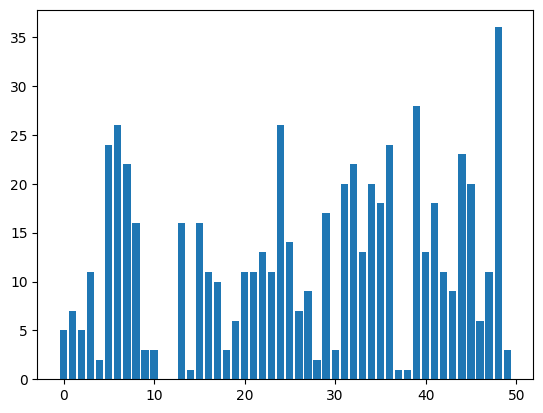

In [ ]:
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt

path_class = DATA_FOLDER_PATH +"classes.txt"
class_animal = pd.read_table(path_class,header= None)
# class_animal
animals = class_animal[1]
dict_label_animal = {}
n = 0
for i in range(0,len(animals)):
    dict_label_animal[animals[i]] = n
    n+=1
def label_to_num(tuple_labels):
    list_labels =[]
    for tuple_label in tuple_labels:
        list_labels.append(dict_label_animal[tuple_label])
    return torch.tensor(list_labels) 

nb_wrong_pred = []
for i in range(0,50):
    nb_wrong_pred.append(wrong_pred.count(i))

list_animal = list(dict_label_animal.keys())

plt.bar(range(50), nb_wrong_pred)
plt.show()

## 4. Classes correctement prédites:

In [ ]:
good_classification = []
bad_classification = []
for i in range(50):
    if nb_wrong_pred[i]<=75:
        good_classification.append(i)
    if nb_wrong_pred[i]>=100:
        bad_classification.append(i)

def find_right_animal(m):
    wrong_pred_m =[]
    for j in [i for i,x in enumerate(wrong_pred) if x == m]:
        wrong_pred_m.append(right_label[j])
    return list_animal[max(wrong_pred_m,key = wrong_pred_m.count)]

for i in good_classification :
    print('Model a bien classifie '+animals[i])

Model a bien classifie antelope
Model a bien classifie grizzly+bear
Model a bien classifie killer+whale
Model a bien classifie beaver
Model a bien classifie dalmatian
Model a bien classifie persian+cat
Model a bien classifie horse
Model a bien classifie german+shepherd
Model a bien classifie blue+whale
Model a bien classifie siamese+cat
Model a bien classifie skunk
Model a bien classifie mole
Model a bien classifie tiger
Model a bien classifie hippopotamus
Model a bien classifie leopard
Model a bien classifie moose
Model a bien classifie spider+monkey
Model a bien classifie humpback+whale
Model a bien classifie elephant
Model a bien classifie gorilla
Model a bien classifie ox
Model a bien classifie fox
Model a bien classifie sheep
Model a bien classifie seal
Model a bien classifie chimpanzee
Model a bien classifie hamster
Model a bien classifie squirrel
Model a bien classifie rhinoceros
Model a bien classifie rabbit
Model a bien classifie bat
Model a bien classifie giraffe
Model a bien

## 5. Classes faussement prédites:

In [ ]:
for i in bad_classification:
  print('Model a mal classifie '+animals[i]+' , melange souvent avec '+find_right_animal(i))